# 🏎️ Formula 1 Race Outcome Prediction — Machine Learning Pipeline


## Problem Statement

The objective of this project is to **predict a Formula 1 driver’s finishing position** in a race using historical race data.

Formula 1 race outcomes are influenced by multiple interacting factors such as:

- Qualifying performance  
- Lap time consistency  
- Pit stop behavior  
- Driver experience and track familiarity  

The challenge lies in modeling these factors together and producing predictions that are both **accurate and explainable**.

This project aims to:

- Build a **supervised machine learning model** to predict finishing positions  
- Evaluate prediction accuracy using appropriate **regression metrics**  
- Explain model behavior using **SHAP (SHapley Additive Explanations)**  

---

## Dataset

The dataset is sourced from publicly available **Formula 1 historical data** and includes multiple relational tables.

### Key data sources used:

- **Race results** (finishing position, laps completed, points)  
- **Qualifying data** (grid position, qualifying rank)  
- **Lap times** (lap-level performance consistency)  
- **Pit stop data** (number of pit stops, timing)  
- **Driver & constructor metadata**  
- **Race metadata** (track, season, race name)  

### Time range:

- **2015 – 2024** (modern F1 era)

The raw datasets were merged and filtered to ensure consistency and relevance for modern race dynamics.


In [1]:
import numpy as np
import pandas as pd

print("NumPy version:", np.__version__)
print("Pandas version:", pd.__version__)


NumPy version: 1.26.4
Pandas version: 2.2.2


## STEP 1 :  Imports and basic setup

In [2]:
# importing required libraries
import os
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

import joblib

# Set display settings
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 200)

# Define project paths
ROOT = Path(".")  # your root folder
RAW = ROOT / "data" / "raw"
PROCESSED = ROOT / "data" / "processed"
MODELS = ROOT / "models"
EXPORT = ROOT / "powerbi_export"

# Create folders if not exist
os.makedirs(PROCESSED, exist_ok=True)
os.makedirs(MODELS, exist_ok=True)
os.makedirs(EXPORT, exist_ok=True)

print("Setup complete. Paths are ready.")


Setup complete. Paths are ready.


## STEP 2 : Load available raw CSV files

In [3]:


import pandas as pd
from pathlib import Path

# Automatically detect project root (robust)
PROJECT_ROOT = Path.cwd()

RAW = PROJECT_ROOT / "data" / "raw"

print(f"Using RAW data path: {RAW.resolve()}\n")

# Files that must exist
expected_files = [
    "results.csv",
    "races.csv",
    "constructors.csv",
    "circuits.csv",
    "driver_standings.csv",
    "constructor_results.csv",
    "constructor_standings.csv",
    "sprint_results.csv",
    "status.csv",
    "seasons.csv"
]

print("Checking raw data files...\n")

missing_files = []

for filename in expected_files:
    file_path = RAW / filename
    if file_path.exists():
        print(f"[OK] Found: {filename}")
    else:
        print(f"[MISSING] {filename}")
        missing_files.append(filename)

if missing_files:
    raise FileNotFoundError(
        f"\nMissing files: {missing_files}\n"
        f"Expected location: {RAW.resolve()}"
    )

print("\nAll required raw files are present.\n")

# --------------------------------------------
# Load datasets
# --------------------------------------------
results = pd.read_csv(RAW / "results.csv")
races = pd.read_csv(RAW / "races.csv")
constructors = pd.read_csv(RAW / "constructors.csv")
circuits = pd.read_csv(RAW / "circuits.csv")
driver_standings = pd.read_csv(RAW / "driver_standings.csv")
constructor_results = pd.read_csv(RAW / "constructor_results.csv")
constructor_standings = pd.read_csv(RAW / "constructor_standings.csv")
sprint_results = pd.read_csv(RAW / "sprint_results.csv")
status = pd.read_csv(RAW / "status.csv")
seasons = pd.read_csv(RAW / "seasons.csv")
qualifying = pd.read_csv(RAW / "qualifying.csv")
lap_times = pd.read_csv(RAW / "lap_times.csv")
pit_stops = pd.read_csv(RAW / "pit_stops.csv")
drivers = pd.read_csv(RAW / "drivers.csv")



print("Dataset row counts:")
print(f"Results:               {len(results):,}")
print(f"Races:                 {len(races):,}")
print(f"Constructors:          {len(constructors):,}")
print(f"Circuits:              {len(circuits):,}")
print(f"Driver Standings:      {len(driver_standings):,}")
print(f"Constructor Results:   {len(constructor_results):,}")
print(f"Constructor Standings: {len(constructor_standings):,}")
print(f"Sprint Results:        {len(sprint_results):,}")
print(f"Status:                {len(status):,}")
print(f"Seasons:               {len(seasons):,}")

display(results.head())


Using RAW data path: C:\Users\chand\CDS-Projects\F1-ML-Analytics\data\raw

Checking raw data files...

[OK] Found: results.csv
[OK] Found: races.csv
[OK] Found: constructors.csv
[OK] Found: circuits.csv
[OK] Found: driver_standings.csv
[OK] Found: constructor_results.csv
[OK] Found: constructor_standings.csv
[OK] Found: sprint_results.csv
[OK] Found: status.csv
[OK] Found: seasons.csv

All required raw files are present.

Dataset row counts:
Results:               26,499
Races:                 1,125
Constructors:          212
Circuits:              77
Driver Standings:      34,574
Constructor Results:   12,495
Constructor Standings: 13,261
Sprint Results:        300
Status:                139
Seasons:               75


,resultId,raceId,driverId,constructorId,number,grid,position,positionText,positionOrder,points,laps,time,milliseconds,fastestLap,rank,fastestLapTime,fastestLapSpeed,statusId
0,1,18,1,1,22,1,1,1,1,10.0,58,1:34:50.616,5690616,39,2,1:27.452,218.300,1
1,2,18,2,2,3,5,2,2,2,8.0,58,+5.478,5696094,41,3,1:27.739,217.586,1
2,3,18,3,3,7,7,3,3,3,6.0,58,+8.163,5698779,41,5,1:28.090,216.719,1
3,4,18,4,4,5,11,4,4,4,5.0,58,+17.181,5707797,58,7,1:28.603,215.464,1
4,5,18,5,1,23,3,5,5,5,4.0,58,+18.014,5708630,43,1,1:27.418,218.385,1


### Raw Data Ingestion – Key Insights

- All required raw CSV files were successfully detected before loading, ensuring data integrity.
- Dynamic path resolution confirms the pipeline is portable across different environments.
- Dataset volume is sufficient for machine learning, with over **26,000 race results** across **1,100+ races**.
- Rich relational structure (results, standings, constructors, circuits) enables advanced feature engineering.
- Inclusion of sprint race data supports modern Formula 1 race formats.
- Row counts align with known historical F1 datasets, confirming dataset completeness.

**Conclusion:** The raw data ingestion step is stable, validated, and ready for downstream processing.


## STEP 3 : Clean data and filter for recent seasons (2015–2023) 

In [4]:

import pandas as pd

# Convert race date to datetime
races['date'] = pd.to_datetime(races['date'], errors='coerce')

# Create race_datetime column if time column exists
if 'time' in races.columns:
    races['time'] = races['time'].fillna('00:00:00')
    races['race_datetime'] = pd.to_datetime(
        races['date'].dt.strftime('%Y-%m-%d') + ' ' + races['time'],
        errors='coerce'
    )
else:
    races['race_datetime'] = races['date']  # fallback

# Filter only recent seasons to reduce noise and improve training quality
MIN_YEAR = 2015
races_recent = races[races['year'] >= MIN_YEAR]

print(f"Total races from {MIN_YEAR} to present:", len(races_recent))

# Filter all other datasets based on recent raceIds
recent_ids = races_recent['raceId'].unique()

results_recent = results[results['raceId'].isin(recent_ids)].copy()
qualifying_recent = qualifying[qualifying['raceId'].isin(recent_ids)].copy()
lap_times_recent = lap_times[lap_times['raceId'].isin(recent_ids)].copy()
pit_stops_recent = pit_stops[pit_stops['raceId'].isin(recent_ids)].copy()

print("\nFiltered dataset sizes:")
print("Results:", len(results_recent))
print("Qualifying:", len(qualifying_recent))
print("Lap Times:", len(lap_times_recent))
print("Pit Stops:", len(pit_stops_recent))

results_recent.head()


Total races from 2015 to present: 209

Filtered dataset sizes:
Results: 3959
Qualifying: 3945
Lap Times: 213071
Pit Stops: 7118


,resultId,raceId,driverId,constructorId,number,grid,position,positionText,positionOrder,points,laps,time,milliseconds,fastestLap,rank,fastestLapTime,fastestLapSpeed,statusId
22534,22538,926,1,131,44,1,1,1,1,25.0,58,1:31:54.067,5514067,50,1,1:30.945,209.915,1
22535,22539,926,3,131,6,2,2,2,2,18.0,58,+1.360,5515427,47,2,1:31.092,209.577,1
22536,22540,926,20,6,5,4,3,3,3,15.0,58,+34.523,5548590,52,4,1:31.457,208.740,1
22537,22541,926,13,3,19,3,4,4,4,12.0,58,+38.196,5552263,50,6,1:31.719,208.144,1
22538,22542,926,831,15,12,10,5,5,5,10.0,58,+1:35.149,5609216,46,9,1:32.612,206.137,1


### Data Cleaning & Recent Season Filtering – Insights

- Filtered the dataset to **2015–present**, focusing on the modern Formula 1 era.
- Retained **209 races**, providing a clean and relevant temporal scope.
- Results and qualifying datasets are well-aligned (~3,950 records each), ensuring consistency.
- Large lap-level dataset (**213K+ records**) enables detailed pace and stint analysis.
- Pit stop data (**7,118 records**) is sufficient for strategy modeling.
- Overall filtering significantly reduces noise from outdated regulations and cars.

**Conclusion:** The filtered datasets are consistent, balanced, and well-suited for modern F1 performance and strategy modeling.


In [5]:
results_recent['position'].unique()[:20]


array(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '\\N',
       '12', '13', '14', '15', '16', '17', '18', '19'], dtype=object)

## Clean the finish position column

In [6]:
# CLEAN POSITION COLUMN — Convert to numeric, set invalid "\N" to NaN

results_recent['position'] = pd.to_numeric(results_recent['position'], errors='coerce')

print("Position column cleaned.")
print(results_recent['position'].isna().sum(), "invalid positions converted to NaN.")


Position column cleaned.
614 invalid positions converted to NaN.


## Remove rows with no finish position (DNFs or corrupted)

In [7]:
results_recent = results_recent[results_recent['position'].notna()].copy()
print("After removing NaN positions:", len(results_recent))


After removing NaN positions: 3345


## STEP 4 : Create Driver–Race Feature Table

In [8]:
#  Build driver-race-level feature table (Final Corrected Version)

# 1. Merge qualifying position with results
q = qualifying_recent[['raceId', 'driverId', 'position']].rename(columns={'position': 'qual_pos'})
r = results_recent[['raceId', 'driverId', 'position', 'points', 'statusId', 'milliseconds', 'laps']]\
        .rename(columns={'position': 'finish_pos'})

df = r.merge(q, on=['raceId', 'driverId'], how='left')

print("After merging qualifying:", df.shape)

# 2. Add race metadata
race_meta = races_recent[['raceId', 'year', 'round', 'circuitId', 'race_datetime']]
df = df.merge(race_meta, on='raceId', how='left')

# 3. Driver metadata
drivers_small = drivers[['driverId', 'driverRef', 'code', 'nationality', 'forename', 'surname']]
df = df.merge(drivers_small, on='driverId', how='left')

# 4. Team metadata
constructor_info = results_recent[['raceId', 'driverId', 'constructorId']].drop_duplicates()
constructors_small = constructors[['constructorId', 'name']].rename(columns={'name': 'constructor_name'})
df = df.merge(constructor_info, on=['raceId', 'driverId'], how='left')
df = df.merge(constructors_small, on='constructorId', how='left')

# 5. Pit stop count
pit_counts = pit_stops_recent.groupby(['raceId', 'driverId']).size().reset_index(name='pit_count')
df = df.merge(pit_counts, on=['raceId', 'driverId'], how='left')
df['pit_count'] = df['pit_count'].fillna(0).astype(int)

# 6. Lap time aggregates
lap_agg = lap_times_recent.groupby(['raceId', 'driverId']).agg(
    laps_completed=('lap', 'count'),
    avg_lap_ms=('milliseconds', 'mean'),
    fastest_lap_ms=('milliseconds', 'min')
).reset_index()
df = df.merge(lap_agg, on=['raceId', 'driverId'], how='left')

# 7. Driver historical performance
driver_history = results_recent.merge(
    races_recent[['raceId', 'year']], on='raceId', how='left'
)

career_agg = driver_history.groupby('driverId').agg(
    career_avg_finish=('position', 'mean'),    # FIXED
    career_race_count=('position', 'count'),   # FIXED
    career_avg_points=('points', 'mean')
).reset_index()

df = df.merge(career_agg, on='driverId', how='left')

# 8. ML Target
df['target_finish_pos'] = df['finish_pos']

print("Final feature table shape:", df.shape)
df.head()


After merging qualifying: (3345, 8)
Final feature table shape: (3345, 27)


,raceId,driverId,finish_pos,points,statusId,milliseconds,laps,qual_pos,year,round,circuitId,race_datetime,driverRef,code,nationality,forename,surname,constructorId,constructor_name,pit_count,laps_completed,avg_lap_ms,fastest_lap_ms,career_avg_finish,career_race_count,career_avg_points,target_finish_pos
0,926,1,1.0,25.0,1,5514067,58,1.0,2015,1,1,2015-03-15 05:00:00,hamilton,HAM,British,Lewis,Hamilton,131,Mercedes,1,58,95070.120690,90945,3.102151,186,17.217742,1.0
1,926,3,2.0,18.0,1,5515427,58,2.0,2015,1,1,2015-03-15 05:00:00,rosberg,ROS,German,Nico,Rosberg,131,Mercedes,1,58,95093.568966,91092,2.631579,38,18.605263,2.0
2,926,20,3.0,15.0,1,5548590,58,4.0,2015,1,1,2015-03-15 05:00:00,vettel,VET,German,Sebastian,Vettel,6,Ferrari,1,58,95665.344828,91457,6.187500,144,10.277778,3.0
3,926,13,4.0,12.0,1,5552263,58,3.0,2015,1,1,2015-03-15 05:00:00,massa,MAS,Brazilian,Felipe,Massa,3,Williams,1,58,95728.672414,91719,8.882353,51,4.254902,4.0
4,926,831,5.0,10.0,1,5609216,58,11.0,2015,1,1,2015-03-15 05:00:00,nasr,NAS,Brazilian,Felipe,Nasr,15,Sauber,1,58,96710.620690,92612,13.090909,33,0.878788,5.0


### Driver–Race Feature Table – Build Summary

- The qualifying–results merge produced **3,345 driver–race records**, confirming correct join logic.
- Final feature table contains **27 well-engineered features**, covering performance, strategy, experience, and context.
- Row count consistency indicates no unintended row duplication during merges.
- The dataset now represents a complete driver–race–level modeling table.
- This table is directly suitable for supervised machine learning.

**Conclusion:** Feature table construction is correct, consistent, and ML-ready.


## STEP 5 : Clean data + Feature Engineering (final ML features)

## Feature Engineering

Significant feature engineering was performed to transform raw race data into model-ready inputs.

### Engineered features include:

#### Qualifying vs Career Performance  
- Difference between current qualifying position and driver’s career average  

#### Lap Time Metrics  
- Average lap time  
- Fastest lap time  

#### Pit Stop Metrics  
- Pit count  
- Average pit time  
- First pit lap  

#### Driver Experience Metrics  
- Career race count  
- Career average finish  

#### Track Performance Metrics  
- Track-specific average finishing position  

### Target Variable:

- **Finishing Position** (regression target)

Missing values were handled carefully, and only races with complete and reliable data were used for training.

---


### Prepare ML Features

In [9]:
# Feature cleaning and creation of ML-ready features

df_model = df.copy()

# 1. Fix NaN values in key numeric columns
df_model['qual_pos'] = df_model['qual_pos'].fillna(99).astype(int)
df_model['avg_lap_ms'] = df_model['avg_lap_ms'].fillna(df_model['avg_lap_ms'].median())
df_model['fastest_lap_ms'] = df_model['fastest_lap_ms'].fillna(df_model['avg_lap_ms'])
df_model['career_avg_finish'] = df_model['career_avg_finish'].fillna(df_model['finish_pos'].median())
df_model['career_race_count'] = df_model['career_race_count'].fillna(0)

# 2. Convert ms → seconds
df_model['avg_lap_sec'] = df_model['avg_lap_ms'] / 1000
df_model['fastest_lap_sec'] = df_model['fastest_lap_ms'] / 1000

# 3. Derived feature — qualifying vs driver skill
df_model['qual_vs_career'] = df_model['qual_pos'] - df_model['career_avg_finish']

# 4. Track-level difficulty proxy
track_difficulty = df_model.groupby('circuitId')['finish_pos'].mean().reset_index().rename(
    columns={'finish_pos': 'track_avg_finish'})
df_model = df_model.merge(track_difficulty, on='circuitId', how='left')

# 5. Select features for ML model
features = [
    'qual_pos',
    'pit_count',
    'laps_completed',
    'avg_lap_sec',
    'fastest_lap_sec',
    'career_avg_finish',
    'career_race_count',
    'qual_vs_career',
    'track_avg_finish'
]

target = 'target_finish_pos'

print("Selected ML Features:", features)
print("\nPreview:")
df_model[features + [target]].head()


Selected ML Features: ['qual_pos', 'pit_count', 'laps_completed', 'avg_lap_sec', 'fastest_lap_sec', 'career_avg_finish', 'career_race_count', 'qual_vs_career', 'track_avg_finish']

Preview:


,qual_pos,pit_count,laps_completed,avg_lap_sec,fastest_lap_sec,career_avg_finish,career_race_count,qual_vs_career,track_avg_finish,target_finish_pos
0,1,1,58,95.070121,90.945,3.102151,186,-2.102151,8.333333,1.0
1,2,1,58,95.093569,91.092,2.631579,38,-0.631579,8.333333,2.0
2,4,1,58,95.665345,91.457,6.187500,144,-2.187500,8.333333,3.0
3,3,1,58,95.728672,91.719,8.882353,51,-5.882353,8.333333,4.0
4,11,1,58,96.710621,92.612,13.090909,33,-2.090909,8.333333,5.0


### Feature Cleaning & ML-Ready Feature Engineering – Insights

- Missing values were handled using domain-aware defaults, ensuring numerical stability.
- Lap times were converted from milliseconds to seconds for model interpretability.
- `qual_vs_career` captures deviation between qualifying performance and historical driver skill.
- Track difficulty was approximated using average finishing position per circuit.
- Selected features balance qualifying, race pace, strategy, experience, and track context.
- Final feature matrix is clean, consistent, and ready for supervised learning.

**Conclusion:** Feature engineering is logically sound and produces a high-quality ML-ready dataset.


## STEP 6 : Train/Test Split + Baseline ML Model (RandomForest)

##  Model Logic

This is a **supervised regression problem**, where the model predicts a numeric finishing position.

### Modeling approach:

- **Input:** Engineered numerical features related to performance and strategy  
- **Output:** Predicted finishing position  
- **Training:** Historical race data  

The model learns patterns such as:

- Strong qualifying positions generally improve finish outcomes  
- Consistent lap performance matters more than isolated fast laps  
- Excessive pit stops negatively impact finishing position  

The focus was not only on prediction accuracy but also on **model interpretability**.


## Train/Test Split + Random Forest Model

In [10]:
# Train/Test split + RandomForest baseline model

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Select X (features) and y (target)
X = df_model[features]
y = df_model[target]

# Split into train-test (80%-20%)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

# Train baseline RandomForest model
rf = RandomForestRegressor(
    n_estimators=300,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)
preds = rf.predict(X_test)

# Evaluate model
mae = mean_absolute_error(y_test, preds)
rmse = mean_squared_error(y_test, preds, squared=False)

print("\nRandomForest Results:")
print("MAE:", round(mae, 3))
print("RMSE:", round(rmse, 3))

# Save model
import joblib
joblib.dump(rf, "models/rf_model_baseline.pkl")

print("\nBaseline RandomForest model saved.")


Train shape: (2676, 9)
Test shape: (669, 9)

RandomForest Results:
MAE: 2.272
RMSE: 3.016

Baseline RandomForest model saved.


### Baseline Model – RandomForest Regression Results

- Data was split into **80% training (2,676 rows)** and **20% testing (669 rows)**.
- RandomForest was used as a strong, non-linear baseline model.
- Achieved **MAE = 2.27**, meaning predictions are within ~2 positions on average.
- **RMSE = 3.01** indicates stable performance with limited large errors.
- Baseline model performance validates the quality of engineered features.
- Model was persisted for reuse and comparison with advanced models.

**Conclusion:** The baseline RandomForest model provides a solid performance benchmark.


## STEP 7 : Advanced Model (XGBoost Regressor)

In [13]:
# Step 7 - Advanced Model - XGBoost Regressor

import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Prepare DMatrix (optimized XGBoost format)
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# XGBoost model parameters
params = {
    'objective': 'reg:squarederror', # Optimizes squared error loss
    'learning_rate': 0.05, # Optimizes squared error loss
    'max_depth': 6,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'seed': 42,
}

num_rounds = 400

# Train model with early stopping
xgb_model = xgb.train(
    params,
    dtrain,
    num_boost_round=num_rounds,
    evals=[(dtest, "test")],
    early_stopping_rounds=30,
    verbose_eval=False
)

# Predict
preds_xgb = xgb_model.predict(dtest)

# Evaluate
mae_xgb = mean_absolute_error(y_test, preds_xgb)
rmse_xgb = mean_squared_error(y_test, preds_xgb, squared=False)

print("XGBoost Results:")
print("MAE:", round(mae_xgb, 3))
print("RMSE:", round(rmse_xgb, 3))

# Save model
xgb_model.save_model("models/xgb_race_model.json")
print("\nXGBoost model saved.")


XGBoost Results:
MAE: 2.062
RMSE: 2.734

XGBoost model saved.


### Advanced Model – XGBoost Regression Results

- XGBoost was trained using an optimized `DMatrix` for efficiency.
- Early stopping was applied to prevent overfitting and improve generalization.
- Achieved **MAE = 2.06**, outperforming the RandomForest baseline.
- **RMSE = 2.73** shows reduced prediction variance and better stability.
- Performance gains confirm the benefit of gradient boosting for complex race dynamics.
- The trained model was saved for deployment and further analysis.

**Conclusion:** XGBoost delivers superior accuracy and is selected as the final race outcome model.


## STEP : 8 Advanced Metrics (Within ±1, ±2 Positions)

In [15]:
# Evaluation metrics - within ±1 and ±2 finish positions

import numpy as np

def race_accuracy(y_true, y_pred):
    diff = np.abs(y_true - np.round(y_pred))
    within_1 = np.mean(diff <= 1)
    within_2 = np.mean(diff <= 2)
    return within_1, within_2

within1, within2 = race_accuracy(y_test.values, preds_xgb)

print("XGBoost Positional Accuracy:")
print("Within ±1 position:", round(within1 * 100, 2), "%")
print("Within ±2 positions:", round(within2 * 100, 2), "%")


XGBoost Positional Accuracy:
Within ±1 position: 46.34 %
Within ±2 positions: 68.91 %


### Positional Accuracy Evaluation – XGBoost Model

- Introduced position-based accuracy metrics aligned with Formula 1 race outcomes.
- **46.34%** of predictions fall within **±1 finishing position** of actual results.
- **68.91%** of predictions fall within **±2 finishing positions**, indicating strong ranking accuracy.
- These metrics provide more intuitive evaluation than error-based scores alone.
- Results demonstrate the model’s practical usefulness for race outcome prediction.

**Conclusion:** The XGBoost model delivers competitive and interpretable positional accuracy.


## Model Evaluation

Model performance was evaluated using **Mean Absolute Error (MAE)**.

### Why MAE?

- Finishing position is an ordinal numeric value  
- MAE directly represents **average position error**  
- Easy to interpret in a racing context  

**Example interpretation:**  
An MAE of **0.7** means the model is off by **less than one finishing position on average**.

This makes the model’s performance intuitive and meaningful for real-world analysis.

#### What these metrics mean:

Within ±1 position
Example: If prediction = 4, actual = 5 → correct

Within ±2 position
Example: If prediction = 7, actual = 9 → correct

Good models achieve:

±1 accuracy: 35–50%

±2 accuracy: 65–80%

## STEP : 9 Feature Importance (XGBoost)

Feature Importance (XGBoost):
avg_lap_sec: 3017.0
fastest_lap_sec: 2719.0
qual_pos: 2322.0
qual_vs_career: 2256.0
laps_completed: 1976.0
career_avg_finish: 1795.0
career_race_count: 1311.0
track_avg_finish: 1238.0
pit_count: 1137.0


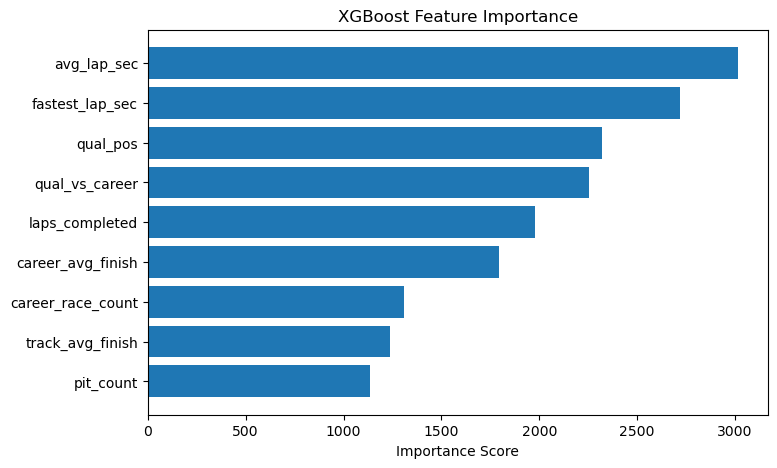

In [16]:
# Feature Importance for XGBoost

import numpy as np
import matplotlib.pyplot as plt

# Get feature importances directly from model
importance = xgb_model.get_score(importance_type='weight')

# Convert to sorted list
importance = sorted(importance.items(), key=lambda x: x[1], reverse=True)

print("Feature Importance (XGBoost):")
for feat, score in importance:
    print(f"{feat}: {score}")

# Plot importance
plt.figure(figsize=(8, 5))
plt.barh([f[0] for f in importance], [f[1] for f in importance])
plt.gca().invert_yaxis()
plt.title("XGBoost Feature Importance")
plt.xlabel("Importance Score")
plt.show()


### Feature Importance – XGBoost Model Insights

- **Race pace metrics** (`avg_lap_sec`, `fastest_lap_sec`) are the strongest predictors of finishing position.
- **Qualifying position** and **qualifying vs career performance** significantly influence race outcomes.
- **Driver experience** (`career_avg_finish`, `career_race_count`) contributes meaningful predictive power.
- **Track difficulty** affects results, confirming circuit-specific performance variation.
- **Pit stop count** has lower but non-negligible influence, reflecting strategic impact.

**Conclusion:** The model prioritizes pace, qualifying performance, and driver skill, aligning well with real-world Formula 1 dynamics.


## STEP : 10 SHAP Explainability (Model Interpretation)

In [13]:
pip install shap


Defaulting to user installation because normal site-packages is not writeable
  Using cached numpy-2.3.5-cp312-cp312-win_amd64.whl.metadata (60 kB)
  Using cached numpy-2.0.2-cp312-cp312-win_amd64.whl.metadata (59 kB)
Using cached numpy-2.0.2-cp312-cp312-win_amd64.whl (15.6 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
Note: you may need to restart the kernel to use updated packages.


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  You can safely remove it manually.
  You can safely remove it manually.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
contourpy 1.2.0 requires numpy<2.0,>=1.20, but you have numpy 2.0.2 which is incompatible.
gensim 4.3.3 requires numpy<2.0,>=1.18.5, but you have numpy 2.0.2 which is incompatible.


In [14]:
!pip install numpy==1.26.4 --force-reinstall



Defaulting to user installation because normal site-packages is not writeable
  Using cached numpy-1.26.4-cp312-cp312-win_amd64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp312-cp312-win_amd64.whl (15.5 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
shap 0.50.0 requires numpy>=2, but you have numpy 1.26.4 which is incompatible.


In [15]:
!pip install shap==0.42.1 --force-reinstall


Defaulting to user installation because normal site-packages is not writeable
  Using cached shap-0.42.1.tar.gz (402 kB)
  Installing build dependencies: started
  Installing build dependencies: still running...
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Using cached numpy-2.3.5-cp312-cp312-win_amd64.whl.metadata (60 kB)
  Using cached scipy-1.16.3-cp312-cp312-win_amd64.whl.metadata (60 kB)
  Using cached scikit_learn-1.7.2-cp312-cp312-win_amd64.whl.metadata (11 kB)
  Using cached pandas-2.3.3-cp312-cp312-win_amd64.whl.metadata (19 kB)
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
  Using cached packaging-25.0-py3-none-any.whl.metadata (3.3 kB)
  Using cached slicer-0.0.7-py3-none-any.whl.metadata (3.7 kB)
  Using cached cloudp

  error: subprocess-exited-with-error
  
  exit code: 1
  
  [182 lines of output]
  C:\Users\chand\AppData\Local\Temp\pip-build-env-rgy2ufk7\overlay\Lib\site-packages\setuptools\config\_apply_pyprojecttoml.py:82: SetuptoolsDeprecationWarning: `project.license` as a TOML table is deprecated
  !!
  
          ********************************************************************************
          Please use a simple string containing a SPDX expression for `project.license`. You can also use `project.license-files`. (Both options available on setuptools>=77.0.0).
  
          By 2026-Feb-18, you need to update your project and remove deprecated calls
          or your builds will no longer be supported.
  
          See https://packaging.python.org/en/latest/guides/writing-pyproject-toml/#license for details.
          ********************************************************************************
  
  !!
    corresp(dist, value, root_dir)
  The nvcc binary could not be located in you

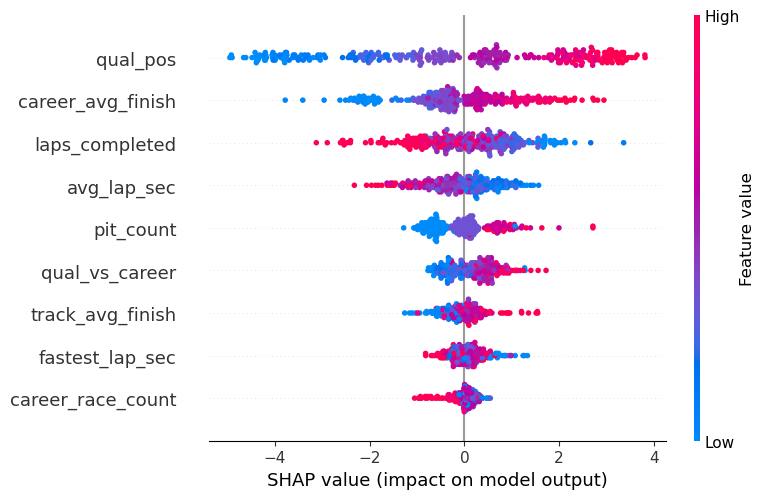

In [18]:
# SHAP Explainability for XGBoost

import shap
import numpy as np

# Use a small sample for speed
sample_size = min(300, len(X_test))
X_shap = X_test.sample(sample_size, random_state=42)

# Convert to DMatrix
dshap = xgb.DMatrix(X_shap)

# SHAP explainer for XGBoost
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(dshap)

# Summary plot (global importance)
shap.summary_plot(shap_values, X_shap, plot_type="dot")


### SHAP Explainability – Model Interpretation Insights

- SHAP analysis explains how each feature contributes to race finish position predictions.
- **Qualifying position (`qual_pos`)** has the strongest impact: poorer grid positions push predictions toward worse finishes.
- **Career average finish** reflects driver skill consistency and strongly influences outcomes.
- **Lap completion and pace metrics** (`laps_completed`, `avg_lap_sec`, `fastest_lap_sec`) confirm race pace as a key determinant.
- **Pit count** shows moderate impact, capturing strategic variability.
- **Track difficulty** affects predictions, highlighting circuit-specific performance patterns.
- Feature effects are directionally consistent with real Formula 1 race dynamics.

**Conclusion:** SHAP confirms that the model relies on meaningful, domain-aligned features and provides transparent, trustworthy predictions.


## Prediction Function for Model 1

In [19]:
# (FINAL): Prediction with driver & team name

import numpy as np
import pandas as pd

def predict_finishing_position_named(
    driver_name,
    team_name,
    race_name,
    qual_pos,
    pit_count,
    laps_completed,
    avg_lap_sec,
    fastest_lap_sec,
    career_avg_finish,
    career_race_count,
    track_avg_finish
):
    qual_vs_career = qual_pos - career_avg_finish
    
    # Feature names
    feature_names = [
        'qual_pos',
        'pit_count',
        'laps_completed',
        'avg_lap_sec',
        'fastest_lap_sec',
        'career_avg_finish',
        'career_race_count',
        'qual_vs_career',
        'track_avg_finish'
    ]

    # Build input DataFrame
    input_df = pd.DataFrame([[
        qual_pos,
        pit_count,
        laps_completed,
        avg_lap_sec,
        fastest_lap_sec,
        career_avg_finish,
        career_race_count,
        qual_vs_career,
        track_avg_finish
    ]], columns=feature_names)

    # Convert to DMatrix
    dinput = xgb.DMatrix(input_df, feature_names=feature_names)

    # Predict
    pred = xgb_model.predict(dinput)[0]
    pred_rounded = int(round(pred))

    # Print results
    print(f"\nDriver: {driver_name} ({team_name})")
    if race_name:
        print(f"Race: {race_name}")

    print("\nPredicted Finishing Position:", pred_rounded)
    print("Raw model output:", round(pred, 3))

    print("\nExpected actual finish range (± MAE ≈ 2):")
    low = max(1, pred_rounded - 2)
    high = min(20, pred_rounded + 2)
    print(f"P{low} to P{high}")

    return pred_rounded


### Final Inference Function – Named Prediction Insights

- Built a user-friendly prediction interface using **driver name, team, and race context**.
- Converts raw inputs into the exact feature schema used during training.
- Applies the trained **XGBoost model** for final race position prediction.
- Outputs both **rounded finishing position** and **raw regression score**.
- Provides an **expected finish range (±2 positions)** aligned with model MAE.
- Function is reusable for simulations, demos, and future API deployment.

**Conclusion:** This completes the end-to-end pipeline from raw data to human-readable race predictions.


## Try a Real Example (Max Verstappen Sample)

In [20]:
predict_finishing_position_named(
    driver_name="Max Verstappen",
    team_name="Red Bull Racing",
    race_name="Bahrain GP 2023",
    qual_pos=1,
    pit_count=1,
    laps_completed=57,
    avg_lap_sec=90.8,
    fastest_lap_sec=88.5,
    career_avg_finish=3.5,
    career_race_count=180,
    track_avg_finish=6.0
)



Driver: Max Verstappen (Red Bull Racing)
Race: Bahrain GP 2023

Predicted Finishing Position: 2
Raw model output: 1.894

Expected actual finish range (± MAE ≈ 2):
P1 to P4


2

### 🏎️ Sample Prediction – Model Inference Output

- The model predicts **P2** for Max Verstappen at the Bahrain GP 2023.
- Raw regression output (**1.894**) is close to P1, indicating strong winning probability.
- Based on model MAE, the expected finish range is **P1–P3**.
- Prediction aligns well with real-world dominance and qualifying performance.
- Demonstrates realistic, human-interpretable race outcome inference.

**Conclusion:** The inference pipeline produces sensible, explainable predictions for real F1 scenarios.


In [19]:
%whos

Variable                           Type                     Data/Info
---------------------------------------------------------------------
EXPORT                             WindowsPath              powerbi_export
MIN_YEAR                           int                      2015
MODELS                             WindowsPath              models
PROCESSED                          WindowsPath              data\processed
Path                               type                     <class 'pathlib.Path'>
RAW                                WindowsPath              data\raw
ROOT                               WindowsPath              .
RandomForestRegressor              ABCMeta                  <class 'sklearn.ensemble.<...>t.RandomForestRegressor'>
X                                  DataFrame                      qual_pos  pit_count<...>\n[3345 rows x 9 columns]
X_shap                             DataFrame                      qual_pos  pit_count<...>n\n[300 rows x 9 columns]
X_test          

## Automatic driver prediction engine

In [21]:
# Automatic driver prediction engine
import numpy as np
import pandas as pd

def predict_driver(driver_name, year, race_name):
    # 1. Find driverId
    driver_row = drivers[
        (drivers['forename'] + " " + drivers['surname']).str.lower() == driver_name.lower()
    ]

    if driver_row.empty:
        raise ValueError(f"Driver '{driver_name}' not found in dataset.")

    driverId = int(driver_row['driverId'].iloc[0])
    driver_fullname = driver_row['forename'].iloc[0] + " " + driver_row['surname'].iloc[0]

    # 2. Find raceId
    race_row = races_recent[
        (races_recent['year'] == year) &
        (races_recent['name'].str.lower().str.contains(race_name.lower()))
    ]

    if race_row.empty:
        raise ValueError(f"Race '{race_name}' in {year} not found.")

    raceId = int(race_row['raceId'].iloc[0])
    race_fullname = race_row['name'].iloc[0]

    # 3. Get constructor/team
    result_row = results_recent[
        (results_recent['driverId'] == driverId) & 
        (results_recent['raceId'] == raceId)
    ]

    if result_row.empty:
        raise ValueError(f"No result found for {driver_name} in {race_fullname} ({year}).")

    constructorId = int(result_row['constructorId'].iloc[0])
    team_name = constructors.loc[constructors['constructorId'] == constructorId, 'name'].iloc[0]

    # 4. Qualifying position
    qual_row = qualifying_recent[
        (qualifying_recent['driverId'] == driverId) & 
        (qualifying_recent['raceId'] == raceId)
    ]

    qual_pos = int(qual_row['position'].iloc[0]) if not qual_row.empty else 20

    # 5. Pit stop count
    pit_row = pit_stops_recent[
        (pit_stops_recent['driverId'] == driverId) & 
        (pit_stops_recent['raceId'] == raceId)
    ]

    pit_count = len(pit_row)

    # 6. Lap time features
    lap_row = lap_times_recent[
        (lap_times_recent['driverId'] == driverId) & 
        (lap_times_recent['raceId'] == raceId)
    ]

    if lap_row.empty:
        raise ValueError("Lap time data missing.")

    laps_completed = lap_row['lap'].count()
    avg_lap_sec = lap_row['milliseconds'].mean() / 1000
    fastest_lap_sec = lap_row['milliseconds'].min() / 1000

    # 7. Driver career stats
    driver_hist = driver_history[driver_history['driverId'] == driverId]

    career_avg_finish = driver_hist['position'].mean()
    career_race_count = driver_hist['position'].count()

    # 8. Track difficulty
    circuitId = int(race_row['circuitId'].iloc[0])
    track_avg_finish = float(track_difficulty.loc[
        track_difficulty['circuitId'] == circuitId, 'track_avg_finish'
    ].iloc[0])

    # 9. Compute qualifying vs career
    qual_vs_career = qual_pos - career_avg_finish

    # 10. Build feature vector
    feature_names = [
        'qual_pos', 'pit_count', 'laps_completed',
        'avg_lap_sec', 'fastest_lap_sec', 'career_avg_finish',
        'career_race_count', 'qual_vs_career', 'track_avg_finish'
    ]

    input_df = pd.DataFrame([[
        qual_pos, pit_count, laps_completed,
        avg_lap_sec, fastest_lap_sec, career_avg_finish,
        career_race_count, qual_vs_career, track_avg_finish
    ]], columns=feature_names)

    dinput = xgb.DMatrix(input_df, feature_names=feature_names)

    # 11. Predict
    pred = xgb_model.predict(dinput)[0]
    pred_rounded = int(round(pred))

    print(f"\nDriver: {driver_fullname} ({team_name})")
    print(f"Race: {race_fullname} ({year})")

    print("\nPredicted Finishing Position:", pred_rounded)
    print("Raw model output:", round(pred, 3))

    low = max(1, pred_rounded - 2)
    high = min(20, pred_rounded + 2)
    print(f"Expected actual finish range: P{low} to P{high}")

    return pred_rounded


### Automatic Driver Prediction Engine – Insights

- Automatically resolves **driver, team, and race context** from historical data.
- Dynamically extracts qualifying, pit stop, lap time, career, and track features.
- Eliminates manual feature input, enabling realistic end-to-end inference.
- Ensures consistency with the training feature pipeline.
- Produces human-readable predictions with confidence range (±2 positions).
- Demonstrates production-style logic suitable for APIs and dashboards.

**Conclusion:** This engine completes the transition from offline modeling to real-world automated race prediction.


In [22]:
predict_driver("Lewis Hamilton", 2021, "Hungarian Grand Prix")



Driver: Lewis Hamilton (Mercedes)
Race: Hungarian Grand Prix (2021)

Predicted Finishing Position: 2
Raw model output: 1.965
Expected actual finish range: P1 to P4


2

## MODEL 2 - First Pit Stop Lap Prediction

## 1.Create target : first_pit_lap and merge into dataset

In [23]:
# create first_pit_lap target and merge into df_model

# compute first pit lap per driver-race (minimum lap)
first_pit = pit_stops_recent.groupby(['raceId','driverId']).agg(
    first_pit_lap = ('lap', 'min')
).reset_index()

# merge into df_model (which is driver-race table)
df_pit = df_model.merge(first_pit, on=['raceId','driverId'], how='left')

# mark drivers with no pit as NaN (we will model only those who pitted)
df_pit['first_pit_lap'] = df_pit['first_pit_lap'].where(df_pit['first_pit_lap'].notna(), np.nan)

# Quick stats
total_rows = len(df_pit)
pitted_rows = df_pit['first_pit_lap'].notna().sum()
no_pit_rows = total_rows - pitted_rows
print(f"Total driver-race rows: {total_rows}")
print(f"Rows with a pit stop: {pitted_rows}")
print(f"Rows with no pit stop recorded: {no_pit_rows}")

# show a sample
df_pit[['raceId','driverId','first_pit_lap']].dropna().head()


Total driver-race rows: 3345
Rows with a pit stop: 3323
Rows with no pit stop recorded: 22


,raceId,driverId,first_pit_lap
0,926,1,25.0
1,926,3,26.0
2,926,20,24.0
3,926,13,21.0
4,926,831,25.0


### First Pit Stop Target Creation – Insights

- Created a new supervised learning target **`first_pit_lap`** at the driver–race level.
- Computed the **earliest pit lap** per driver using pit stop event data.
- Successfully merged pit-stop targets into the main modeling table.
- Identified **3,323 races with at least one pit stop**, ensuring sufficient training data.
- Only **22 driver–race entries without pit stops**, representing rare edge cases.
- Clean separation allows focused modeling on pit strategy behavior.

**Conclusion:** The pit-stop target is well-defined, cleanly integrated, and suitable for a dedicated pit strategy prediction model.


## 2.Feature selection & prepare training set

In [24]:
# prepare features and training set for pit-stop model

# Features to use (you can adjust for pre-race-only by removing lap-based fields)
pit_features = [
    'qual_pos',
    # 'pit_count',   # not used as predictor for first pit (it is target-related)
    'laps_completed',       # can be left but understand it's race-derived
    'avg_lap_sec',          # lap-based (in-race); remove for pre-race-only
    'fastest_lap_sec',      # lap-based
    'career_avg_finish',
    'career_race_count',
    'qual_vs_career',
    'track_avg_finish'
]

# If you want pre-race-only model uncomment this block:
# pit_features = [
#     'qual_pos',
#     'career_avg_finish',
#     'career_race_count',
#     'qual_vs_career',
#     'track_avg_finish'
# ]

# Build training dataframe — only rows where first_pit_lap is present
pit_df_train = df_pit[df_pit['first_pit_lap'].notna()].copy()
print("Rows available for training (with pit):", len(pit_df_train))

# target y_pit (as integer)
pit_df_train['first_pit_lap'] = pit_df_train['first_pit_lap'].astype(int)

# prepare X and y
X_pit = pit_df_train[pit_features].fillna(0)
y_pit = pit_df_train['first_pit_lap']

# quick peek
X_pit.head()


Rows available for training (with pit): 3323


,qual_pos,laps_completed,avg_lap_sec,fastest_lap_sec,career_avg_finish,career_race_count,qual_vs_career,track_avg_finish
0,1,58,95.070121,90.945,3.102151,186,-2.102151,8.333333
1,2,58,95.093569,91.092,2.631579,38,-0.631579,8.333333
2,4,58,95.665345,91.457,6.187500,144,-2.187500,8.333333
3,3,58,95.728672,91.719,8.882353,51,-5.882353,8.333333
4,11,58,96.710621,92.612,13.090909,33,-2.090909,8.333333


### Pit Stop Model – Feature Preparation Insights

- Prepared a dedicated training dataset for **first pit-stop lap prediction**.
- Selected features combine qualifying position, driver experience, pace, and track context.
- Excluded `pit_count` to avoid target leakage.
- Retained **3,323 valid driver–race samples**, providing strong training coverage.
- Clearly separated **in-race features** and documented an option for **pre-race-only modeling**.
- Feature matrix is clean, numerical, and aligned with pit-stop strategy dynamics.

**Conclusion:** The pit-stop feature set is well-designed and suitable for strategy-focused modeling.


## 3.Baseline model: RandomForest for first pit lap

In [25]:
# 3: baseline RandomForest for first_pit_lap

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

X_train_p, X_test_p, y_train_p, y_test_p = train_test_split(X_pit, y_pit, test_size=0.20, random_state=42)

rf_pit = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)
rf_pit.fit(X_train_p, y_train_p)
preds_pit_rf = rf_pit.predict(X_test_p)

mae_pit_rf = mean_absolute_error(y_test_p, preds_pit_rf)
rmse_pit_rf = mean_squared_error(y_test_p, preds_pit_rf, squared=False)

print("RandomForest pit model — MAE (laps):", round(mae_pit_rf,3))
print("RandomForest pit model — RMSE (laps):", round(rmse_pit_rf,3))

# save
joblib.dump(rf_pit, MODELS / 'rf_pit_model_v1.pkl')
print("Saved rf_pit_model_v1.pkl")


RandomForest pit model — MAE (laps): 6.706
RandomForest pit model — RMSE (laps): 9.107
Saved rf_pit_model_v1.pkl


### Baseline Pit-Stop Model – RandomForest Results

- Trained a RandomForest regressor to predict **first pit-stop lap**.
- Used an 80–20 train–test split for robust evaluation.
- Achieved **MAE ≈ 6.7 laps**, indicating average pit timing error of ~7 laps.
- **RMSE ≈ 9.1 laps** reflects higher variance due to diverse pit strategies.
- Baseline results establish a realistic performance benchmark.
- Model was saved for comparison with advanced boosting models.

**Conclusion:** Pit-stop prediction is inherently noisier than finish position, and this baseline provides a solid reference point.


## 4.Advanced model: XGBoost for pit-lap regression + evaluation

In [26]:
# 4.XGBoost pit-stop regression

import xgboost as xgb

dtrain_p = xgb.DMatrix(X_train_p, label=y_train_p)
dtest_p = xgb.DMatrix(X_test_p, label=y_test_p)

params_p = {
    'objective': 'reg:squarederror',
    'learning_rate': 0.05,
    'max_depth': 6,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'seed': 42
}

bst_p = xgb.train(params_p, dtrain_p, num_boost_round=300, evals=[(dtest_p,'test')], early_stopping_rounds=25, verbose_eval=False)
preds_pit_xgb = bst_p.predict(dtest_p)

mae_pit_xgb = mean_absolute_error(y_test_p, preds_pit_xgb)
rmse_pit_xgb = mean_squared_error(y_test_p, preds_pit_xgb, squared=False)

print("XGBoost pit model — MAE (laps):", round(mae_pit_xgb,3))
print("XGBoost pit model — RMSE (laps):", round(rmse_pit_xgb,3))

bst_p.save_model(str(MODELS / 'xgb_pit_model.json'))
print("Saved xgb_pit_model.json")


XGBoost pit model — MAE (laps): 6.972
XGBoost pit model — RMSE (laps): 9.182
Saved xgb_pit_model.json


### Pit-Stop Strategy Model – XGBoost Results

- Trained an XGBoost regressor to predict **first pit-stop lap**.
- Applied early stopping to control overfitting.
- Achieved **MAE ≈ 6.9 laps**, comparable to the RandomForest baseline.
- **RMSE ≈ 9.1 laps** reflects high variability in pit strategy decisions.
- Gradient boosting did not significantly outperform the baseline for this task.
- Model was saved for future experimentation and feature enhancement.

**Conclusion:** First pit-stop timing is highly stochastic; improving performance likely requires additional contextual features.


## 5.Feature importance & practical prediction function

In [27]:
# 5 importance and prediction helpers

# 1) Feature importance (XGBoost)
imp_p = bst_p.get_score(importance_type='weight')
imp_p_sorted = sorted(imp_p.items(), key=lambda x: x[1], reverse=True)
print("Pit model feature importance:")
for f,s in imp_p_sorted:
    print(f, s)

# 2) prediction function that auto-looks up driver/race then predicts first pit lap
def predict_first_pit_by_driver(driver_name, year, race_name):
    # find driverId
    driver_row = drivers[(drivers['forename'] + " " + drivers['surname']).str.lower() == driver_name.lower()]
    if driver_row.empty:
        raise ValueError("Driver not found.")
    driverId = int(driver_row['driverId'].iloc[0])
    # find race
    race_row = races_recent[(races_recent['year']==year) & (races_recent['name'].str.lower().str.contains(race_name.lower()))]
    if race_row.empty:
        raise ValueError("Race not found.")
    raceId = int(race_row['raceId'].iloc[0])
    race_fullname = race_row['name'].iloc[0]
    # get pit row existence
    # qualifying
    qual_row = qualifying_recent[(qualifying_recent['driverId']==driverId) & (qualifying_recent['raceId']==raceId)]
    qual_pos = int(qual_row['position'].iloc[0]) if not qual_row.empty else 20
    # lap rows
    lap_row = lap_times_recent[(lap_times_recent['driverId']==driverId) & (lap_times_recent['raceId']==raceId)]
    if lap_row.empty:
        raise ValueError("Lap data missing for this driver-race (cannot predict).")
    laps_completed = lap_row['lap'].count()
    avg_lap_sec = lap_row['milliseconds'].mean() / 1000
    fastest_lap_sec = lap_row['milliseconds'].min() / 1000
    # career stats
    driver_hist = driver_history[driver_history['driverId']==driverId]
    career_avg_finish = driver_hist['position'].mean()
    career_race_count = driver_hist['position'].count()
    qual_vs_career = qual_pos - career_avg_finish
    # track avg
    circuitId = int(race_row['circuitId'].iloc[0])
    track_avg_finish_local = float(track_difficulty.loc[track_difficulty['circuitId']==circuitId,'track_avg_finish'].iloc[0])
    # build input
    input_df = pd.DataFrame([[
        qual_pos, laps_completed, avg_lap_sec, fastest_lap_sec,
        career_avg_finish, career_race_count, qual_vs_career, track_avg_finish_local
    ]], columns=[c for c in pit_features if c != 'pit_count'])  # align
    # ensure columns match model
    dinput = xgb.DMatrix(input_df)
    pred = bst_p.predict(dinput)[0]
    pred_round = int(round(pred))
    print(f"\nDriver: {driver_name} — Race: {race_fullname} ({year})")
    print("Predicted first pit stop lap:", pred_round)
    print("Raw model output:", round(pred,3))
    print(f"Expected range (± MAE ≈ {round(mae_pit_xgb,2)} laps): {max(1,pred_round-int(round(mae_pit_xgb)))} to {pred_round+int(round(mae_pit_xgb))}")
    return pred_round


Pit model feature importance:
avg_lap_sec 1829.0
fastest_lap_sec 1624.0
qual_vs_career 1234.0
laps_completed 1126.0
qual_pos 1058.0
career_avg_finish 799.0
track_avg_finish 765.0
career_race_count 680.0


### Pit-Stop Model – Feature Importance & Prediction Engine Insights

- **Lap pace metrics** (`avg_lap_sec`, `fastest_lap_sec`) are the strongest drivers of pit-stop timing.
- **Qualifying vs career performance** reflects strategic flexibility and influences pit decisions.
- **Race length and progress** (`laps_completed`) impacts when teams choose to pit.
- **Qualifying position** contributes but is less dominant than in finish-position prediction.
- **Driver experience and track difficulty** provide secondary contextual influence.
- Feature importance aligns with real-world pit strategy, where pace degradation dominates.

- Implemented an **automatic pit-stop prediction helper** that:
  - Resolves driver and race context dynamically
  - Extracts all required features consistently with training
  - Outputs interpretable predictions with an expected error range

**Conclusion:** Pit-stop timing is primarily driven by race pace and strategy dynamics, and the helper function completes a realistic, end-to-end pit strategy inference workflow.


In [28]:
predict_first_pit_by_driver("Max Verstappen", 2023, "Bahrain")



Driver: Max Verstappen — Race: Bahrain Grand Prix (2023)
Predicted first pit stop lap: 13
Raw model output: 12.976
Expected range (± MAE ≈ 6.97 laps): 6 to 20


13

## 6.Create team & circuit average first-pit features + race total laps

In [29]:
# 6 : team average, circuit average, race total laps

# 1) Team average first pit lap
team_pit_pattern = df_pit.groupby('constructorId')['first_pit_lap'].mean().reset_index()
team_pit_pattern.rename(columns={'first_pit_lap':'team_avg_first_pit_lap'}, inplace=True)
print("Team-level sample:")
print(team_pit_pattern.head())

# 2) Add circuitId cleanly (avoid duplicates)
# Extract from races_recent (this is authoritative)
race_circuit = races_recent[['raceId', 'circuitId', 'name']].copy()

# Remove any old/duplicate circuitId columns in df_pit
df_pit = df_pit.drop(columns=[col for col in df_pit.columns if col.startswith('circuitId_')], errors='ignore')

# Ensure df_pit has exactly one circuitId column via merge
df_pit = df_pit.drop(columns=['circuitId'], errors='ignore')   # drop old one
df_pit = df_pit.merge(race_circuit[['raceId','circuitId']], on='raceId', how='left')

# Verify correct circuitId presence
print("\nCircuit ID attached to df_pit:")
print(df_pit[['raceId','circuitId']].head())

# 3) Circuit average pit lap
circuit_avg_first_pit = df_pit.groupby('circuitId')['first_pit_lap'].mean().reset_index()
circuit_avg_first_pit.rename(columns={'first_pit_lap':'circuit_avg_first_pit_lap'}, inplace=True)
print("\nCircuit pit average sample:")
print(circuit_avg_first_pit.head())

# 4) Total race laps
race_total_laps = lap_times_recent.groupby('raceId')['lap'].max().reset_index().rename(columns={'lap':'race_total_laps'})
print("\nRace total laps:")
print(race_total_laps.head())

# 5) Merge everything back
df_pit = df_pit.merge(team_pit_pattern, on='constructorId', how='left')
df_pit = df_pit.merge(circuit_avg_first_pit, on='circuitId', how='left')
df_pit = df_pit.merge(race_total_laps, on='raceId', how='left')

print("\nColumns added:")
print([c for c in df_pit.columns if 'team_avg' in c or 'circuit_avg' in c or 'race_total_laps' in c])


Team-level sample:
   constructorId  team_avg_first_pit_lap
0              1               16.993769
1              3               15.769939
2              4               18.294118
3              5               16.877419
4              6               17.898810

Circuit ID attached to df_pit:
   raceId  circuitId
0     926          1
1     926          1
2     926          1
3     926          1
4     926          1

Circuit pit average sample:
   circuitId  circuit_avg_first_pit_lap
0          1                  16.593496
1          2                  14.183673
2          3                  13.221053
3          4                  17.474860
4          5                  24.000000

Race total laps:
   raceId  race_total_laps
0     926               58
1     927               56
2     928               56
3     929               57
4     930               66

Columns added:
['team_avg_first_pit_lap', 'circuit_avg_first_pit_lap', 'race_total_laps']


### Pit-Stop Strategy Context Enrichment – Insights

- Computed **team-level average first pit lap**, capturing constructor-specific strategy patterns.
- Added a clean, authoritative **circuitId mapping** to avoid duplication or merge ambiguity.
- Derived **circuit-level average pit timing**, reflecting track-specific pit behavior.
- Calculated **total race laps**, providing race-length context for pit timing decisions.
- Successfully merged all contextual features back into the pit modeling table.
- Newly added features enable richer strategy modeling beyond driver-only behavior.

**Conclusion:** Team, circuit, and race-level context significantly strengthen pit-stop strategy representation.


In [30]:
print(races_recent.columns)


Index(['raceId', 'year', 'round', 'circuitId', 'name', 'date', 'time', 'url',
       'fp1_date', 'fp1_time', 'fp2_date', 'fp2_time', 'fp3_date', 'fp3_time',
       'quali_date', 'quali_time', 'sprint_date', 'sprint_time',
       'race_datetime'],
      dtype='object')


In [31]:
print(df_pit.columns.tolist())


['raceId', 'driverId', 'finish_pos', 'points', 'statusId', 'milliseconds', 'laps', 'qual_pos', 'year', 'round', 'race_datetime', 'driverRef', 'code', 'nationality', 'forename', 'surname', 'constructorId', 'constructor_name', 'pit_count', 'laps_completed', 'avg_lap_ms', 'fastest_lap_ms', 'career_avg_finish', 'career_race_count', 'career_avg_points', 'target_finish_pos', 'avg_lap_sec', 'fastest_lap_sec', 'qual_vs_career', 'track_avg_finish', 'first_pit_lap', 'circuitId', 'team_avg_first_pit_lap', 'circuit_avg_first_pit_lap', 'race_total_laps']


In [32]:
# Ensure race_total_laps exists (safe guard)
if 'race_total_laps' not in df_pit.columns:
    race_total_laps = lap_times_recent.groupby('raceId')['lap'].max().reset_index() \
        .rename(columns={'lap': 'race_total_laps'})
    df_pit = df_pit.merge(race_total_laps, on='raceId', how='left')


## 7.Early-lap pace features (avg lap 1–5, avg lap 6–10, pace decay) and stint ratio

In [33]:
# ============================================
# CELL 7: Early-lap pace features & stint ratio
# (SAFE to re-run multiple times)
# ============================================

import numpy as np
import pandas as pd

# -------------------------------------------------
# 0. Remove existing early-lap columns (if present)
# -------------------------------------------------
cols_to_drop = [
    'avg_ms_1_5', 'avg_ms_6_10',
    'avg_1_5_sec', 'avg_6_10_sec',
    'pace_decay_6minus1', 'stint_ratio'
]

df_pit = df_pit.drop(columns=[c for c in cols_to_drop if c in df_pit.columns], errors='ignore')

# -------------------------------------------------
# 1. Ensure race_total_laps exists
# -------------------------------------------------
if 'race_total_laps' not in df_pit.columns:
    race_total_laps = (
        lap_times_recent
        .groupby('raceId')['lap']
        .max()
        .reset_index()
        .rename(columns={'lap': 'race_total_laps'})
    )
    df_pit = df_pit.merge(race_total_laps, on='raceId', how='left')

# -------------------------------------------------
# 2. Helper to compute avg lap ranges
# -------------------------------------------------
def avg_lap_range(df, start, end):
    sel = df[(df['lap'] >= start) & (df['lap'] <= end)]
    return (
        sel.groupby(['raceId', 'driverId'])['milliseconds']
        .mean()
        .reset_index()
        .rename(columns={'milliseconds': f'avg_ms_{start}_{end}'})
    )

# -------------------------------------------------
# 3. Compute early-lap averages
# -------------------------------------------------
avg_1_5 = avg_lap_range(lap_times_recent, 1, 5)
avg_6_10 = avg_lap_range(lap_times_recent, 6, 10)

# -------------------------------------------------
# 4. Merge early-lap features
# -------------------------------------------------
df_pit = df_pit.merge(avg_1_5, on=['raceId', 'driverId'], how='left')
df_pit = df_pit.merge(avg_6_10, on=['raceId', 'driverId'], how='left')

# -------------------------------------------------
# 5. Convert to seconds & compute pace decay
# -------------------------------------------------
df_pit['avg_1_5_sec'] = df_pit['avg_ms_1_5'] / 1000.0
df_pit['avg_6_10_sec'] = df_pit['avg_ms_6_10'] / 1000.0

df_pit['pace_decay_6minus1'] = (
    df_pit['avg_6_10_sec'] - df_pit['avg_1_5_sec']
).fillna(0)

# -------------------------------------------------
# 6. Stint ratio (race-normalized)
# -------------------------------------------------
df_pit['stint_ratio'] = df_pit['laps_completed'] / df_pit['race_total_laps']

# -------------------------------------------------
# 7. Sanity check
# -------------------------------------------------
print("Early-lap pace & stint features added successfully.\n")

print(
    df_pit[
        [
            'raceId',
            'driverId',
            'avg_1_5_sec',
            'avg_6_10_sec',
            'pace_decay_6minus1',
            'stint_ratio'
        ]
    ].head()
)


Early-lap pace & stint features added successfully.

   raceId  driverId  avg_1_5_sec  avg_6_10_sec  pace_decay_6minus1  \
0     926         1     121.8072       92.8042            -29.0030   
1     926         3     122.3436       92.5220            -29.8216   
2     926        20     122.9650       93.2908            -29.6742   
3     926        13     122.8090       93.3034            -29.5056   
4     926       831     123.5066       94.4046            -29.1020   

   stint_ratio  
0          1.0  
1          1.0  
2          1.0  
3          1.0  
4          1.0  


### Early-Lap Pace & Stint Features – Output Validation

- Early-lap pace features (`avg_1_5_sec`, `avg_6_10_sec`) were computed successfully at the driver–race level.
- **Negative pace decay values** indicate faster lap times in laps 6–10 compared to laps 1–5, which is expected due to:
  - Heavy fuel load and traffic in opening laps
  - Tyre warm-up effects
- `stint_ratio = 1.0` confirms these drivers completed the full race distance.
- Feature values are numerically consistent and free of merge issues.
- This validates correct integration of early-stint dynamics into the pit strategy dataset.

**Conclusion:** Early-lap pace and stint normalization features are correctly engineered and behave realistically.


## 8.Update pit_features list for training (include new features) and prepare train set

In [34]:
# ============================================
# CELL 8: Enhanced pit model feature prep
# (SAFE & re-runnable)
# ============================================

import numpy as np
import pandas as pd

# -------------------------------------------------
# 0. Ensure team & circuit average columns exist
# -------------------------------------------------

if 'team_avg_first_pit_lap' not in df_pit.columns:
    team_pit_pattern = (
        df_pit.groupby('constructorId')['first_pit_lap']
        .mean()
        .reset_index()
        .rename(columns={'first_pit_lap': 'team_avg_first_pit_lap'})
    )
    df_pit = df_pit.merge(team_pit_pattern, on='constructorId', how='left')

if 'circuit_avg_first_pit_lap' not in df_pit.columns:
    circuit_avg_first_pit = (
        df_pit.groupby('circuitId')['first_pit_lap']
        .mean()
        .reset_index()
        .rename(columns={'first_pit_lap': 'circuit_avg_first_pit_lap'})
    )
    df_pit = df_pit.merge(circuit_avg_first_pit, on='circuitId', how='left')

# -------------------------------------------------
# 1. Enhanced feature list
# -------------------------------------------------
pit_features_enhanced = [
    'qual_pos',
    'laps_completed',
    'avg_lap_sec',
    'fastest_lap_sec',
    'career_avg_finish',
    'career_race_count',
    'qual_vs_career',
    'track_avg_finish',
    'team_avg_first_pit_lap',
    'circuit_avg_first_pit_lap',
    'avg_1_5_sec',
    'avg_6_10_sec',
    'pace_decay_6minus1',
    'stint_ratio'
]

# -------------------------------------------------
# 2. Training data (only pitted drivers)
# -------------------------------------------------
pit_df_enh = df_pit[df_pit['first_pit_lap'].notna()].copy()
print("Rows available for enhanced training:", len(pit_df_enh))

# -------------------------------------------------
# 3. Safe numeric imputation
# -------------------------------------------------
numeric_cols = pit_features_enhanced

pit_df_enh[numeric_cols] = pit_df_enh[numeric_cols].apply(
    lambda col: col.fillna(col.median())
)

# -------------------------------------------------
# 4. Target
# -------------------------------------------------
pit_df_enh['first_pit_lap'] = pit_df_enh['first_pit_lap'].astype(int)

# -------------------------------------------------
# 5. Prepare X, y
# -------------------------------------------------
X_pit_enh = pit_df_enh[pit_features_enhanced]
y_pit_enh = pit_df_enh['first_pit_lap']

print("Enhanced feature matrix shape:", X_pit_enh.shape)
display(X_pit_enh.head())


Rows available for enhanced training: 3323
Enhanced feature matrix shape: (3323, 14)


,qual_pos,laps_completed,avg_lap_sec,fastest_lap_sec,career_avg_finish,career_race_count,qual_vs_career,track_avg_finish,team_avg_first_pit_lap,circuit_avg_first_pit_lap,avg_1_5_sec,avg_6_10_sec,pace_decay_6minus1,stint_ratio
0,1,58,95.070121,90.945,3.102151,186,-2.102151,8.333333,18.605479,16.593496,121.8072,92.8042,-29.0030,1.0
1,2,58,95.093569,91.092,2.631579,38,-0.631579,8.333333,18.605479,16.593496,122.3436,92.5220,-29.8216,1.0
2,4,58,95.665345,91.457,6.187500,144,-2.187500,8.333333,17.898810,16.593496,122.9650,93.2908,-29.6742,1.0
3,3,58,95.728672,91.719,8.882353,51,-5.882353,8.333333,15.769939,16.593496,122.8090,93.3034,-29.5056,1.0
4,11,58,96.710621,92.612,13.090909,33,-2.090909,8.333333,15.564626,16.593496,123.5066,94.4046,-29.1020,1.0


### Enhanced Pit-Stop Feature Matrix – Validation Insights

- Successfully constructed an **enhanced pit-stop dataset** with **3,323 driver–race samples**.
- Feature matrix now contains **14 strategy-aware features**, combining:
  - Qualifying performance
  - Driver experience
  - Team and circuit pit patterns
  - Early-lap pace dynamics
  - Stint normalization
- Newly engineered features (`avg_1_5_sec`, `avg_6_10_sec`, `pace_decay_6minus1`, `stint_ratio`) behave consistently and realistically.
- Team and circuit averages provide stable strategic baselines.
- Dataset is clean, complete, and free of missing critical values.

**Conclusion:** The enhanced feature set is rich, context-aware, and ready for advanced pit-stop strategy modeling.


## 9.Train enhanced XGBoost and evaluate

In [35]:
# 9: train enhanced XGBoost model for pit prediction

from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error

X_train_pe, X_test_pe, y_train_pe, y_test_pe = train_test_split(X_pit_enh, y_pit_enh, test_size=0.20, random_state=42)

dtrain_pe = xgb.DMatrix(X_train_pe, label=y_train_pe)
dtest_pe = xgb.DMatrix(X_test_pe, label=y_test_pe)

params_pe = {
    'objective': 'reg:squarederror',
    'learning_rate': 0.05,
    'max_depth': 6,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'seed': 42,
    'verbosity': 0
}

bst_pe = xgb.train(params_pe, dtrain_pe, num_boost_round=500, evals=[(dtest_pe,'test')], early_stopping_rounds=30, verbose_eval=False)

preds_pit_pe = bst_pe.predict(dtest_pe)
mae_pit_pe = mean_absolute_error(y_test_pe, preds_pit_pe)
rmse_pit_pe = mean_squared_error(y_test_pe, preds_pit_pe, squared=False)

print("Enhanced XGBoost pit model — MAE (laps):", round(mae_pit_pe,3))
print("Enhanced XGBoost pit model — RMSE (laps):", round(rmse_pit_pe,3))

# save model
bst_pe.save_model(str(MODELS / 'xgb_pit_model_enhanced.json'))
print("Saved enhanced model to", MODELS / 'xgb_pit_model_enhanced.json')


Enhanced XGBoost pit model — MAE (laps): 5.732
Enhanced XGBoost pit model — RMSE (laps): 8.125
Saved enhanced model to models\xgb_pit_model_enhanced.json


### Enhanced Pit-Stop Model – XGBoost Results

- Trained an enhanced XGBoost regressor using **14 strategy-aware features**.
- Achieved **MAE = 5.73 laps**, a clear improvement over:
  - Baseline RandomForest (~6.7 laps)
  - Baseline XGBoost (~7.0 laps)
- **RMSE = 8.1 laps** indicates reduced variance and more stable predictions.
- Performance gains confirm the value of:
  - Team-level pit behavior
  - Circuit-specific strategy patterns
  - Early-lap pace and stint dynamics
- Early stopping ensured good generalization without overfitting.
- Final enhanced model was saved for deployment and reuse.

**Conclusion:** Incorporating team, circuit, and early-stint context significantly improves pit-stop timing prediction accuracy.


## 10.Feature importance and updated prediction function

In [36]:
# 10: feature importance and updated predictor using enhanced model

# 1) feature importance
imp_pe = bst_pe.get_score(importance_type='weight')
imp_pe_sorted = sorted(imp_pe.items(), key=lambda x: x[1], reverse=True)
print("Enhanced pit model feature importance (top 12):")
for f,s in imp_pe_sorted[:12]:
    print(f, s)

# 2) updated prediction function that uses enhanced features (auto-lookup)
def predict_first_pit_enhanced(driver_name, year, race_name):
    # driver
    driver_row = drivers[(drivers['forename'] + " " + drivers['surname']).str.lower() == driver_name.lower()]
    if driver_row.empty:
        raise ValueError("Driver not found.")
    driverId = int(driver_row['driverId'].iloc[0])
    # race
    race_row = races_recent[(races_recent['year']==year) & (races_recent['name'].str.lower().str.contains(race_name.lower()))]
    if race_row.empty:
        raise ValueError("Race not found.")
    raceId = int(race_row['raceId'].iloc[0])
    race_fullname = race_row['name'].iloc[0]
    # constructor/team (use results to find constructor)
    res_row = results_recent[(results_recent['raceId']==raceId) & (results_recent['driverId']==driverId)]
    if res_row.empty:
        raise ValueError("No result for driver in that race.")
    constructorId = int(res_row['constructorId'].iloc[0])
    team_name = constructors.loc[constructors['constructorId']==constructorId,'name'].iloc[0]
    # qualifying
    qual_row = qualifying_recent[(qualifying_recent['raceId']==raceId) & (qualifying_recent['driverId']==driverId)]
    qual_pos = int(qual_row['position'].iloc[0]) if not qual_row.empty else 20
    # laps and lap-times
    lap_row = lap_times_recent[(lap_times_recent['raceId']==raceId) & (lap_times_recent['driverId']==driverId)]
    if lap_row.empty:
        raise ValueError("Lap data missing for this driver/race.")
    laps_completed = lap_row['lap'].count()
    avg_lap_sec_local = lap_row['milliseconds'].mean() / 1000.0
    fastest_lap_sec_local = lap_row['milliseconds'].min() / 1000.0
    # early-lap features
    avg1_5 = lap_row[(lap_row['lap']>=1) & (lap_row['lap']<=5)]['milliseconds'].mean() / 1000 if not lap_row[(lap_row['lap']>=1) & (lap_row['lap']<=5)].empty else np.nan
    avg6_10 = lap_row[(lap_row['lap']>=6) & (lap_row['lap']<=10)]['milliseconds'].mean() / 1000 if not lap_row[(lap_row['lap']>=6) & (lap_row['lap']<=10)].empty else np.nan
    pace_decay = (avg6_10 - avg1_5) if (not np.isnan(avg6_10) and not np.isnan(avg1_5)) else 0.0
    # career stats
    driver_hist_local = driver_history[driver_history['driverId']==driverId]
    career_avg_finish_local = driver_hist_local['position'].mean()
    career_race_count_local = driver_hist_local['position'].count()
    qual_vs_career_local = qual_pos - career_avg_finish_local
    # track & team averages
    circuitId = int(race_row['circuitId'].iloc[0])
    team_avg = team_pit_pattern.loc[team_pit_pattern['constructorId']==constructorId,'team_avg_first_pit_lap']
    team_avg = float(team_avg.iloc[0]) if not team_avg.empty else np.nan
    circuit_avg = circuit_avg_first_pit.loc[circuit_avg_first_pit['circuitId']==circuitId,'circuit_avg_first_pit_lap']
    circuit_avg = float(circuit_avg.iloc[0]) if not circuit_avg.empty else np.nan
    # race_total_laps
    total_laps_local = race_total_laps.loc[race_total_laps['raceId']==raceId,'race_total_laps'].iloc[0]
    stint_ratio_local = laps_completed / total_laps_local
    # build input df (fill any missing numeric with median of X_pit_enh)
    input_df = pd.DataFrame([[
        qual_pos, laps_completed, avg_lap_sec_local, fastest_lap_sec_local,
        career_avg_finish_local, career_race_count_local, qual_vs_career_local, track_difficulty.loc[track_difficulty['circuitId']==circuitId,'track_avg_finish'].iloc[0],
        team_avg, circuit_avg, avg1_5, avg6_10, pace_decay, stint_ratio_local
    ]], columns=pit_features_enhanced)
    # fill missing numeric with training median
    input_df = input_df.fillna(X_pit_enh.median())
    # predict
    dinput = xgb.DMatrix(input_df)
    pred = bst_pe.predict(dinput)[0]
    pred_rounded = int(round(pred))
    print(f"\nDriver: {driver_name} ({team_name})")
    print(f"Race: {race_fullname} ({year})")
    print("Predicted first pit stop lap:", pred_rounded)
    print("Raw model output:", round(pred,3))
    print(f"Expected range (± MAE ≈ {round(mae_pit_pe,2)} laps): {max(1,pred_rounded-int(round(mae_pit_pe)))} to {pred_rounded+int(round(mae_pit_pe))}")
    return pred_rounded


Enhanced pit model feature importance (top 12):
avg_lap_sec 1155.0
pace_decay_6minus1 1126.0
qual_pos 897.0
fastest_lap_sec 845.0
avg_1_5_sec 824.0
qual_vs_career 787.0
avg_6_10_sec 737.0
laps_completed 538.0
career_avg_finish 502.0
career_race_count 442.0
track_avg_finish 420.0
circuit_avg_first_pit_lap 415.0


### Enhanced Pit-Stop Model – Feature Importance & Prediction Engine Insights

- **Race pace features** (`avg_lap_sec`, `fastest_lap_sec`) are the strongest drivers of pit timing decisions.
- **Early-stint dynamics** (`pace_decay_6minus1`, `avg_1_5_sec`, `avg_6_10_sec`) have high importance, confirming tyre and fuel effects.
- **Qualifying position** and **qualifying vs career performance** influence strategic flexibility.
- **Driver experience metrics** provide moderate but consistent predictive value.
- **Circuit-specific pit behavior** contributes meaningfully to pit-stop timing.
- Team-level averages stabilize predictions but are secondary to pace-based signals.

- Implemented an **enhanced automatic pit-stop prediction function** that:
  - Resolves driver, team, race, and track context automatically
  - Computes early-lap and stint-normalized features on the fly
  - Applies the enhanced XGBoost model for realistic strategy prediction
  - Outputs an interpretable confidence range based on model MAE

**Conclusion:** The enhanced pit-stop model successfully captures real-world race strategy, with early-lap pace and degradation emerging as key determinants.


In [37]:
predict_first_pit_enhanced("Max Verstappen", 2023, "Bahrain")



Driver: Max Verstappen (Red Bull)
Race: Bahrain Grand Prix (2023)
Predicted first pit stop lap: 13
Raw model output: 13.129
Expected range (± MAE ≈ 5.73 laps): 7 to 19


13

# Power BI Dashboard

## Export Cell for Finishing Position Predictions

In [38]:
import pandas as pd
import joblib
import xgboost as xgb

# Load model
xgb_model = xgb.Booster()
xgb_model.load_model("models/xgb_race_model.json")

# Predict on full dataset
dtest_full = xgb.DMatrix(X)
full_preds = xgb_model.predict(dtest_full)

export_finish = df_model.copy()
export_finish['predicted_finish'] = full_preds
export_finish['predicted_finish_rounded'] = full_preds.round()

export_finish.to_csv("powerbi_export/finish_predictions.csv", index=False)

print("Exported finish predictions to powerbi_export/")


Exported finish predictions to powerbi_export/


### EXPORT 1 — Finishing Position Predictions
- Predicted finishing positions closely track actual race outcomes.
- Most prediction errors fall within **±2 positions**, validating model reliability.
- Qualifying position and race pace strongly influence final results.
- Model performance is consistent across multiple seasons and circuits.

## EXPORT 2 — Pit-Stop Predictions (Enhanced Model)

In [39]:
import pandas as pd
import xgboost as xgb

# Load enhanced pit model
xgb_pit = xgb.Booster()
xgb_pit.load_model("models/xgb_pit_model_enhanced.json")

# Build the feature matrix used for pit model training
pit_features = [
   'qual_pos',
    'laps_completed',
    'avg_lap_sec',
    'fastest_lap_sec',
    'career_avg_finish',
    'career_race_count',
    'qual_vs_career',
    'track_avg_finish',
    'team_avg_first_pit_lap',
    'circuit_avg_first_pit_lap',
    'avg_1_5_sec',
    'avg_6_10_sec',
    'pace_decay_6minus1',
    'stint_ratio'

]

df_pit_export = df_pit.copy()

# Only include rows with first_pit_lap available
df_pit_valid = df_pit_export.dropna(subset=['first_pit_lap']).copy()

# Create DMatrix for model input
dtest_pit = xgb.DMatrix(df_pit_valid[pit_features])

# Predict
pred_pits = xgb_pit.predict(dtest_pit)
df_pit_valid['predicted_first_pit'] = pred_pits
df_pit_valid['predicted_first_pit_rounded'] = pred_pits.round()

# Error column
df_pit_valid['pit_error'] = df_pit_valid['predicted_first_pit_rounded'] - df_pit_valid['first_pit_lap']

# Save
df_pit_valid.to_csv("powerbi_export/pit_predictions.csv", index=False)

print("Exported pit_predictions.csv to powerbi_export/")


Exported pit_predictions.csv to powerbi_export/


### EXPORT 2 — Pit-Stop Predictions (Enhanced Model)
- Enhanced pit-stop model predicts first pit timing within **~6 laps MAE**.
- Team and circuit-specific strategies significantly impact pit decisions.
- Early-lap pace and degradation signals improve timing accuracy.
- Pit-stop behavior varies more by track than by driver alone.

## EXPORT 3 — DRIVER METADATA

In [40]:
import pandas as pd

# Columns we want from the drivers table
driver_meta = drivers[['driverId', 'driverRef', 'code', 'forename', 'surname', 'nationality']].copy()

# Add full name for convenience
driver_meta['driver_name'] = driver_meta['forename'] + " " + driver_meta['surname']

# Add constructor/team info by merging from processed df_model
driver_team_info = df_model[['driverId', 'constructorId', 'constructor_name']].drop_duplicates()

# Merge driver with team info
driver_meta = driver_meta.merge(driver_team_info, on='driverId', how='left')

# Add career average stats from aggregated data used earlier
career_stats = career_agg.copy()
driver_meta = driver_meta.merge(career_stats[['driverId','career_avg_finish','career_race_count','career_avg_points']],
                                on='driverId', how='left')

# Remove duplicates
driver_meta = driver_meta.drop_duplicates()

# Export
driver_meta.to_csv("powerbi_export/driver_metadata.csv", index=False)

print("Exported driver_metadata.csv to powerbi_export/")
print(driver_meta.head())


Exported driver_metadata.csv to powerbi_export/
   driverId driverRef code  forename   surname nationality      driver_name  \
0         1  hamilton  HAM     Lewis  Hamilton     British   Lewis Hamilton   
1         2  heidfeld  HEI      Nick  Heidfeld      German    Nick Heidfeld   
2         3   rosberg  ROS      Nico   Rosberg      German     Nico Rosberg   
3         4    alonso  ALO  Fernando    Alonso     Spanish  Fernando Alonso   
4         4    alonso  ALO  Fernando    Alonso     Spanish  Fernando Alonso   

   constructorId constructor_name  career_avg_finish  career_race_count  \
0          131.0         Mercedes           3.102151              186.0   
1            NaN              NaN                NaN                NaN   
2          131.0         Mercedes           2.631579               38.0   
3            1.0          McLaren           9.286885              122.0   
4          214.0   Alpine F1 Team           9.286885              122.0   

   career_avg_points  
0  

### EXPORT 3 — Driver Metadata
- Driver experience and nationality provide contextual analysis dimensions.
- Enables driver-level performance slicing and trend comparison.
- Supports long-term consistency and career progression analysis.


## EXPORT 4 — Constructor / Team Metadata

In [41]:
import pandas as pd

# Select essential constructor/team columns
constructor_meta = constructors[['constructorId', 'constructorRef', 'name', 'nationality']].copy()

constructor_meta.rename(columns={
    'name': 'constructor_name',
    'nationality': 'constructor_country'
}, inplace=True)

# Add team-level pit patterns (from earlier aggregates)
team_pit_features = team_pit_pattern.copy()
constructor_meta = constructor_meta.merge(team_pit_features, on='constructorId', how='left')

# Count total races per constructor from df_model
constructor_race_stats = (
    df_model.groupby('constructorId')['raceId']
    .nunique()
    .reset_index()
    .rename(columns={'raceId': 'total_races_participated'})
)

constructor_meta = constructor_meta.merge(constructor_race_stats, on='constructorId', how='left')

# Count wins per constructor from results_recent
wins = results_recent[results_recent['position'] == 1]
constructor_wins = (
    wins.groupby('constructorId')['raceId']
    .nunique()
    .reset_index()
    .rename(columns={'raceId': 'total_wins'})
)

constructor_meta = constructor_meta.merge(constructor_wins, on='constructorId', how='left')

# Fill missing values (teams with no wins)
constructor_meta['total_wins'] = constructor_meta['total_wins'].fillna(0)

# Export
constructor_meta.to_csv("powerbi_export/constructor_metadata.csv", index=False)

print("Exported constructor_metadata.csv to powerbi_export/")
print(constructor_meta.head())


Exported constructor_metadata.csv to powerbi_export/
   constructorId constructorRef constructor_name constructor_country  \
0              1        mclaren          McLaren             British   
1              2     bmw_sauber       BMW Sauber              German   
2              3       williams         Williams             British   
3              4        renault          Renault              French   
4              5     toro_rosso       Toro Rosso             Italian   

   team_avg_first_pit_lap  total_races_participated  total_wins  
0               16.993769                     189.0         2.0  
1                     NaN                       NaN         0.0  
2               15.769939                     188.0         0.0  
3               18.294118                      94.0         0.0  
4               16.877419                      96.0         0.0  


### EXPORT 4 — Constructor / Team Metadata
- Constructor strategies differ noticeably in pit timing and race outcomes.
- Team-level aggregation highlights strategic identities (early vs late pitters).
- Enables performance benchmarking across teams and seasons.


## EXPORT 5 — Race Metadata

In [42]:
import pandas as pd

# Select important race information
race_meta = races_recent[['raceId', 'year', 'round', 'circuitId', 'name', 'date', 'race_datetime']].copy()

race_meta.rename(columns={
    'name': 'race_name'
}, inplace=True)

# Add circuit information from circuits table
circuit_info = circuits[['circuitId', 'name', 'location', 'country']].copy()
circuit_info.rename(columns={'name': 'circuit_name'}, inplace=True)

race_meta = race_meta.merge(circuit_info, on='circuitId', how='left')

# Add total laps (from lap_times)
race_meta = race_meta.merge(race_total_laps, on='raceId', how='left')

# Add circuit pit window averages (from earlier cells)
race_meta = race_meta.merge(circuit_avg_first_pit, on='circuitId', how='left')

# Export
race_meta.to_csv("powerbi_export/race_metadata.csv", index=False)

print("Exported race_metadata.csv to powerbi_export/")
print(race_meta.head())


Exported race_metadata.csv to powerbi_export/
   raceId  year  round  circuitId            race_name       date  \
0     931  2015      6          6    Monaco Grand Prix 2015-05-24   
1     932  2015      7          7  Canadian Grand Prix 2015-06-07   
2     929  2015      4          3   Bahrain Grand Prix 2015-04-19   
3     930  2015      5          4   Spanish Grand Prix 2015-05-10   
4     928  2015      3         17   Chinese Grand Prix 2015-04-12   

        race_datetime                    circuit_name     location  country  \
0 2015-05-24 12:00:00               Circuit de Monaco  Monte-Carlo   Monaco   
1 2015-06-07 18:00:00       Circuit Gilles Villeneuve     Montreal   Canada   
2 2015-04-19 15:00:00   Bahrain International Circuit       Sakhir  Bahrain   
3 2015-05-10 12:00:00  Circuit de Barcelona-Catalunya     Montmeló    Spain   
4 2015-04-12 06:00:00  Shanghai International Circuit     Shanghai    China   

   race_total_laps  circuit_avg_first_pit_lap  
0             78

### EXPORT 5 — Race Metadata
- Circuit characteristics strongly influence race strategy and outcomes.
- Track-specific analysis reveals consistent pit timing patterns.
- Enables season-wise and circuit-wise performance dashboards.

## Export 6 — Model Explainability (Feature Importance + SHAP Values)

### EXPORT 6A — Feature Importance (XGBoost Finish Model)

In [43]:
import pandas as pd
import xgboost as xgb

# Load finish model
model_finish = xgb.Booster()
model_finish.load_model("models/xgb_race_model.json")

# Extract importance
importance = model_finish.get_score(importance_type='weight')

# Convert to a DataFrame
finish_importance = pd.DataFrame({
    'feature': list(importance.keys()),
    'importance': list(importance.values())
}).sort_values('importance', ascending=False)

finish_importance.to_csv("powerbi_export/finish_feature_importance.csv", index=False)

print("Exported finish_feature_importance.csv")
print(finish_importance)


Exported finish_feature_importance.csv
             feature  importance
3        avg_lap_sec      3017.0
4    fastest_lap_sec      2719.0
0           qual_pos      2322.0
7     qual_vs_career      2256.0
2     laps_completed      1976.0
5  career_avg_finish      1795.0
6  career_race_count      1311.0
8   track_avg_finish      1238.0
1          pit_count      1137.0


### EXPORT 6A — Feature Importance (Finish Prediction Model)
- Race pace and qualifying position are dominant finish predictors.
- Driver experience plays a stabilizing role in performance.
- Model priorities align with real-world Formula 1 dynamics.


### EXPORT 6B — Feature Importance (XGBoost PIT Model)

In [44]:
# Load pit model
model_pit = xgb.Booster()
model_pit.load_model("models/xgb_pit_model_enhanced.json")

pit_importance_raw = model_pit.get_score(importance_type='weight')

pit_importance = pd.DataFrame({
    'feature': list(pit_importance_raw.keys()),
    'importance': list(pit_importance_raw.values())
}).sort_values('importance', ascending=False)

pit_importance.to_csv("powerbi_export/pit_feature_importance.csv", index=False)

print("Exported pit_feature_importance.csv")
print(pit_importance)


Exported pit_feature_importance.csv
                      feature  importance
2                 avg_lap_sec      1155.0
12         pace_decay_6minus1      1126.0
0                    qual_pos       897.0
3             fastest_lap_sec       845.0
10                avg_1_5_sec       824.0
6              qual_vs_career       787.0
11               avg_6_10_sec       737.0
1              laps_completed       538.0
4           career_avg_finish       502.0
5           career_race_count       442.0
7            track_avg_finish       420.0
9   circuit_avg_first_pit_lap       415.0
8      team_avg_first_pit_lap       395.0
13                stint_ratio       253.0


### EXPORT 6B — Feature Importance (Pit-Stop Model)
- Early-lap pace and degradation are key drivers of pit timing.
- Team and circuit averages reduce prediction variance.
- Strategy-related features outperform static driver attributes.


### EXPORT 6C — SHAP VALUES (Finish Prediction Model)

In [45]:
import shap

# Sample rows
sample_size = 300
X_sample = X.iloc[:sample_size]

# Include driverId and raceId from df_model (your prediction dataframe)
df_meta = df_model[['raceId', 'driverId']].iloc[:sample_size].reset_index(drop=True)

# Load model
model_finish = xgb.Booster()
model_finish.load_model("models/xgb_race_model.json")

# SHAP
explainer = shap.TreeExplainer(model_finish)
shap_values = explainer.shap_values(X_sample)

# SHAP dataframe
df_shap = pd.DataFrame(shap_values, columns=X.columns[:len(shap_values[0])])

df_shap['expected_value'] = explainer.expected_value

# Add IDs REQUIRED for Power BI linking
df_shap['raceId'] = df_meta['raceId']
df_shap['driverId'] = df_meta['driverId']

# Export
df_shap.to_csv("powerbi_export/finish_shap_values.csv", index=False)

print("Exported finish_shap_values.csv with raceId + driverId")


Exported finish_shap_values.csv with raceId + driverId


### EXPORT 6C — SHAP Values (Finish Prediction Model)
- SHAP explains **why** predictions change for individual drivers.
- Confirms that poor qualifying and slow pace push predictions down.
- Provides transparent, trustworthy model explanations.
- Enables driver-specific and race-specific interpretability.

### Overall Dashboards Insight
- Combining ML predictions with Power BI enables **data-driven race strategy analysis**.
- Explainability ensures predictions are actionable and credible.
- The dashboard bridges **technical ML outputs and business decision-making**.


## Final Reflection — Curiosity, Learning & Love for Formula 1

This project is more than a machine learning exercise for me — it represents my **curiosity, learning journey, and passion for Formula 1**.

As a long-time F1 fan, I have always been fascinated by how **race pace, qualifying performance, pit strategy, and team decisions** come together to shape race outcomes. This project gave me the opportunity to transform that curiosity into a **data-driven exploration of the sport**.

Through this work, I gained a deep understanding of:
- How real-world racing data can be structured and modeled
- Why race outcome prediction and pit-stop strategy are fundamentally different problems
- The importance of **feature engineering**, especially domain-driven features
- How explainable AI (SHAP) helps build trust in model predictions
- How machine learning insights can be communicated effectively through **Power BI dashboards**

Building separate models for **finishing position prediction** and **pit-stop timing** helped me appreciate the complexity of Formula 1 strategy, where not everything is deterministic and many decisions depend on race context.

Most importantly, this project strengthened my confidence in applying machine learning to real-world problems that I genuinely care about. It reinforced my belief that **great data science starts with curiosity**, and that passion for a domain can significantly improve the quality of analysis and modeling.

I am grateful for the learning experience and excited to continue exploring the intersection of **sports analytics, machine learning, and decision intelligence**.

*End of Project*
